# Facial Expression Detection

The following notebook aims to create a facial expression detection code using python with cv2, mediapipe and tensorflow.

In [ ]:
import pandas as pd
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import tensorflow as tf

import csv
import os

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

Selection of the program used

In [ ]:
## Program selection {0:normal camera, 1:record body language, 2:predict body language}
program_sel = 2

In [ ]:
if program_sel == 2:
    clf_cat = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
    path_model = "C:/Users/braya/Documents/Python projects/Body Language/vid_model_50k"

    model = tf.keras.models.load_model(filepath=path_model)

In [ ]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    first_frame = True

    while cap.isOpened():
        # reading feed from webcam
        ret, frame = cap.read()

        # Recolor feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags['WRITEABLE'] = False

        # Make detections
        results = holistic.process(image)

        num_coords = len(results.pose_landmarks.landmark) + len(results.face_landmarks.landmark)
        csv_path = "C:/Users/braya/Documents/Python projects/Body Language/df.csv"

        if first_frame == True & program_sel == 1:
            landmarks = ['class']
            for val in range(1,num_coords+1):
                landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

            with open(csv_path, mode='w', newline='') as f:
                csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                csv_writer.writerow(landmarks)
            first_frame = False

        # Recolor image back to RGB for rendering
        image.flags['WRITEABLE'] = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw face landmarks
        mp_drawing.draw_landmarks(image=image,
                                  landmark_list=results.face_landmarks,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                  )

        mp_drawing.draw_landmarks(image=image,
                                  landmark_list=results.face_landmarks,
                                  connections=mp_holistic.FACEMESH_CONTOURS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                  )

        # Right hand
        mp_drawing.draw_landmarks(image=image,
                                  landmark_list=results.right_hand_landmarks,
                                  connections=mp_holistic.HAND_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2)
                                  )

        # Left Hand
        mp_drawing.draw_landmarks(image=image,
                                  landmark_list=results.left_hand_landmarks,
                                  connections=mp_holistic.HAND_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                  )

        # Pose Detections
        mp_drawing.draw_landmarks(image=image,
                                  landmark_list=results.pose_landmarks,
                                  connections=mp_holistic.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=3),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1)
                                  )

        if program_sel != 0:
            # Export coordinates
            try:
                # Extract pose landmarks
                pose = results.pose_landmarks.landmark
                pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())

                # Extract face landmarks
                face = results.face_landmarks.landmark
                face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())

                # Combining landmarks in a single row
                row = pose_row + face_row

                if program_sel == 1:
                    class_name = "UwU"
                    row.insert(0, class_name)

                    # Export csv
                    with open(csv_path, mode='a', newline='') as f:
                        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        csv_writer.writerow(row)

                elif program_sel == 2:
                    pred_nn = model.predict(np.array([row]))
                    gesture_pred = clf_cat[pred_nn.argmax()]
                    gesture_accuracy = pred_nn.max()

                    # Get status box
                    cv2.rectangle(image, (0, 0), (250, 60), (245, 117, 16), -1)

                    # Display Class
                    cv2.putText(image, 'CLASS'
                                , (95, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, gesture_pred
                                , (90, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                    # Display Probabilityq
                    cv2.putText(image, 'PROB'
                                , (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, str(round(number=gesture_accuracy, ndigits=2))
                                , (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            except:
                pass

        # rendering the results to the screen
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break


cap.release()
cv2.destroyAllWindows()

## Training

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

path ="C:/Python projects/Body Language/video_train_balanced.csv"
df = pd.read_csv(path)

clf_cat = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
for key in clf_cat:
    df[df.columns[0]] = df[df.columns[0]].replace([clf_cat[key]], key)

X = np.array(df.drop(columns=df.columns[0]))
y = to_categorical(df[df.columns[0]], num_classes=len(clf_cat))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    shuffle=True,
                                                    test_size=0.4,
                                                    )

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),

    layers.BatchNormalization(),
    layers.Dropout(0.5, noise_shape=None, seed=42),

    # First Layer
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5, noise_shape=None, seed=42),

    # Second Layer
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5, noise_shape=None, seed=42),

    # Third Layer
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5, noise_shape=None, seed=42),

    # Head
    layers.BatchNormalization(),
    layers.Dense(len(clf_cat), activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50000,
)

path_model = "C:/Python projects/Body Language/vid_model"

tf.keras.models.save_model(
    model=model,
    filepath=path_model,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

## Testing

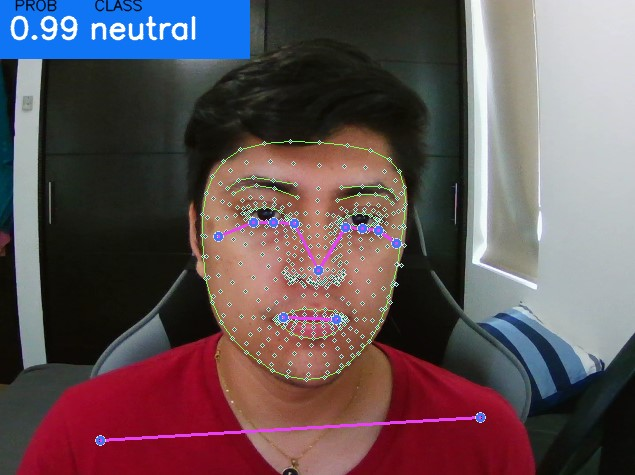

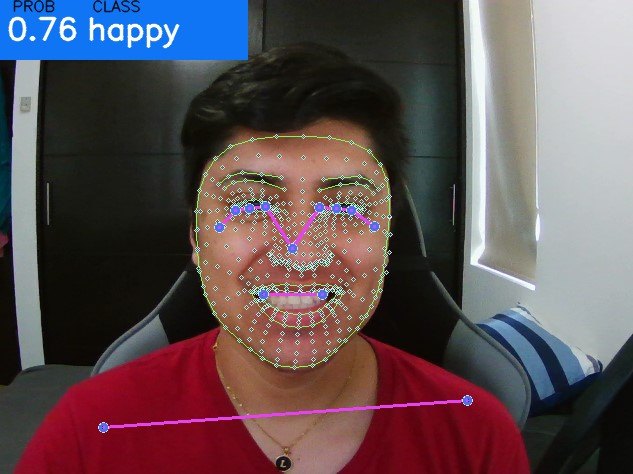

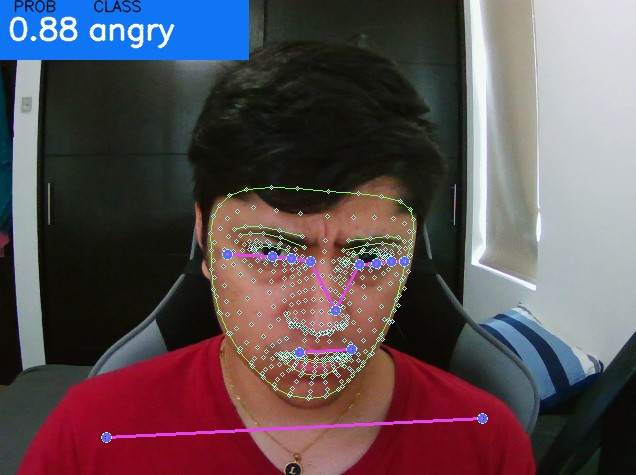